In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

matplotlib.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
    'axes.labelsize': 'large',
    'figure.dpi': 100,
})

In [2]:
# Import all measurements from the `./measurements` directory. Each measurement file
# is read into a numpy array (column-first) and added to the `meas_dict` (keys are
# filenames with extentions removed).
meas_dir = os.fsencode('./measurements')
meas_dict = {}
for fname in os.listdir(meas_dir):
    with open(os.path.join(meas_dir, fname)) as file:
        meas = [[float(el) for el in row.rstrip().split('\t')]
                for row in file.readlines()]
        meas_name = os.fsdecode(fname).removesuffix('.txt')
        meas_dict[meas_name] = np.array(meas).T

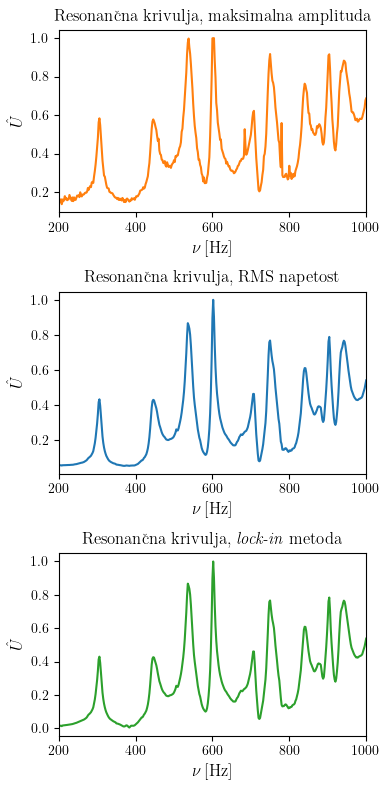

In [3]:
# Normalize response voltage.
ν, U_0, U_0_sq, U_0_lock = meas_dict['res-odziv']
U_0 /= np.max(U_0)
U_0_sq /= np.max(U_0_sq)
U_0_lock /= np.max(U_0_lock)

# Plot.
fig, axs = plt.subplots(3, 1, figsize=[4, 8])

# Magnetisation curve.
axs[0].plot(ν, U_0, color='tab:orange')
axs[1].plot(ν, U_0_sq, color='tab:blue')
axs[2].plot(ν, U_0_lock, color='tab:green')

# Labels and style.
axs[0].set_title('Resonančna krivulja, maksimalna amplituda')
axs[0].set_xlabel(r'$\nu\,[\mathrm{Hz}]$')
axs[0].set_ylabel(r'$\hat U$')
axs[0].set_xlim(np.min(ν), np.max(ν))
axs[1].set_title('Resonančna krivulja, RMS napetost')
axs[1].set_xlabel(r'$\nu\,[\mathrm{Hz}]$')
axs[1].set_ylabel(r'$\hat U$')
axs[1].set_xlim(np.min(ν), np.max(ν))
axs[2].set_title(r'Resonančna krivulja, \textit{lock-in} metoda')
axs[2].set_xlabel(r'$\nu\,[\mathrm{Hz}]$')
axs[2].set_ylabel(r'$\hat U$')
axs[2].set_xlim(np.min(ν), np.max(ν))
fig.tight_layout()
fig.savefig('res-curves.pdf')

In [4]:
c, Δc = 343, 2

A, ΔA = 56.7e-2, 0.1e-2
B, ΔB = 38.5e-2, 0.1e-2
C, ΔC = 24.0e-2, 0.1e-2

In [5]:
def resonances(N):
    '''Returns list of tuples `((n_x, n_y, n_z), ν, Δν)` for resonances with n_x, n_y, n_z running from 0 to `N`.'''
    calc = []
    for n_x in range(N):
        for n_y in range(N):
            for n_z in range(N):
                if not(n_x == 0 and n_y == 0 and n_z == 0):
                    ν = c/2 * np.sqrt(n_x**2 / A**2 + n_y**2 / B**2 + n_z**2 / C**2)
                    Δν = np.sqrt(
                        (1/2 * np.sqrt(n_x**2 / A**2 + n_y**2 / B**2 + n_z**2 / C**2) * Δc)**2 +
                        (-1/4 * n_x**2 / (A * np.sqrt(n_x**2 / A**2 + n_y**2 / B**2 + n_z**2 / C**2)) * ΔA)**2 +
                        (-1/4 * n_y**2 / (B * np.sqrt(n_x**2 / A**2 + n_y**2 / B**2 + n_z**2 / C**2)) * ΔB)**2 +
                        (-1/4 * n_z**2 / (C * np.sqrt(n_x**2 / A**2 + n_y**2 / B**2 + n_z**2 / C**2)) * ΔC)**2
                    )
                    calc.append(((n_x, n_y, n_z), ν, Δν))
    return sorted(calc, key=lambda ns_val_Δ: ns_val_Δ[1])

306.0 22.0
446.0 46.0
536.0 32.0
602.0 20.0
708.0 44.0
750.0 30.0
904.0 24.0


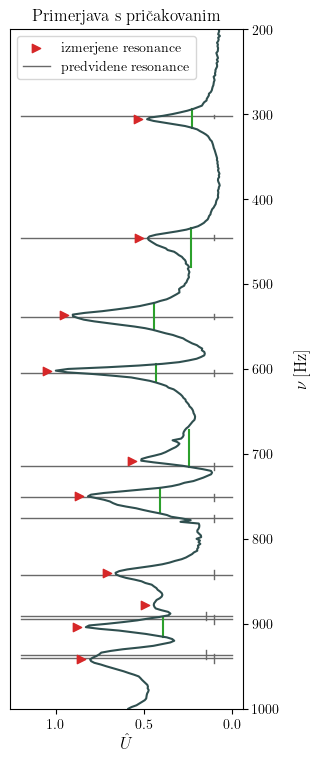

In [6]:
res = resonances(3)

# Average the methods and find peaks.
U_0_mean = (U_0 + U_0_sq + U_0_lock) / 3
peaks, _ = find_peaks(U_0_mean, height=0.4) # Indicies of peaks
peaks = peaks[:-1]

# Plot.
fig, ax = plt.subplots(1, 1, figsize=[3, 9])

# Resonance curve and measured peaks -- resonances.
ax.plot(U_0_mean, ν, color='darkslategrey')
ax.scatter(U_0_mean[peaks] + 0.05, ν[peaks], color='tab:red', marker='>', label=r'izmerjene resonance')

# Draw calculated resonance frequencies.
for i, (_, ν_c, Δν_c) in enumerate(res):
    kwargs = {'label': r'predvidene resonance'} if i == 0 else dict() # Only make label for the first one
    ax.plot([0, 1.2], [ν_c, ν_c], color='dimgray', lw=1, zorder=-2, **kwargs)
    ax.plot([0.15 if (i in {8, 10}) else 0.1]*2, [ν_c - Δν_c, ν_c + Δν_c], color='dimgray', lw=1) # Error bars

# Calculate, draw and print FWHM for most prominent peaks.
for i in [peaks[0], peaks[1], peaks[2], peaks[3], peaks[4], peaks[5], peaks[8]]:
    ν_peak, U_peak = ν[i], U_0_mean[i]
    ν_L, U_L = [(ν, U_0) for ν, U_0 in zip(ν[:i+1], U_0_mean[:i+1])
              if U_0 <= U_peak/2+0.01][-1]
    ν_R, U_R = [(ν, U_0) for ν, U_0 in zip(ν[i:], U_0_mean[i:])
              if U_0 <= U_peak/2+0.01][0]
    ax.plot([(U_L + U_R)/2]*2,[ν_L, ν_R], color='tab:green', zorder=-1)
    print(f'{ν_peak} {ν_R - ν_L:.1f}')

# Labels and style.
ax.set_title(r'Primerjava s pričakovanim')
ax.set_xlabel(r'$\hat U$')
ax.invert_xaxis()
ax.set_ylabel(r'$\nu\,[\mathrm{Hz}]$', labelpad=10)
ax.yaxis.set_label_position('right')
ax.invert_yaxis()
ax.yaxis.tick_right()
ax.set_ylim(np.max(ν), np.min(ν))
ax.legend(loc='upper left')
fig.savefig('peaks.pdf')

In [7]:
# Calculate speed of sound and print table.

ν_peaks = np.insert(ν[peaks], (6, 9), None)
U_0_peaks = np.insert(U_0_mean[peaks], (6, 9), None)

c_Δc = []
for ((n_x, n_y, n_z), ν_calc, Δν_calc), ν_meas, U_0_meas in zip(res, ν_peaks, U_0_peaks):
    c = 2*ν_meas / np.sqrt(n_x**2 / A**2 + n_y**2 / B**2 + n_z**2 / C**2)
    Δc = np.sqrt(
        (2 / np.sqrt(n_x**2 / A**2 + n_y**2 / B**2 + n_z**2 / C**2) * 2)**2 + # Here we cheat and just ues an error of 2 Hz
        (ν_meas * n_x**2 / (A * np.sqrt(n_x**2 / A**2 + n_y**2 / B**2 + n_z**2 / C**2)) * ΔA)**2 +
        (ν_meas * n_y**2 / (B * np.sqrt(n_x**2 / A**2 + n_y**2 / B**2 + n_z**2 / C**2)) * ΔB)**2 +
        (ν_meas * n_z**2 / (C * np.sqrt(n_x**2 / A**2 + n_y**2 / B**2 + n_z**2 / C**2)) * ΔC)**2
    )
    if not np.isnan(c):
        c_Δc.append((c, Δc))
    print(f'({n_x}, {n_y}, {n_z}) & ${ν_calc:.0f} \\pm {Δν_calc:.0f}$ & {ν_meas:.0f} & {U_0_meas:.2f} & ${c:.1f} \\pm {Δc:.1f}$ & {abs(ν_meas - ν_calc):.0f} \\\\')
    
c, Δc = np.array(c_Δc).T

# Mean sound speed and error of the mean.
c_mean = np.average(c, weights=1/Δc**2)
Δc_mean = np.mean(Δc) / np.sqrt(len(c))
c_mean, Δc_mean

(1, 0, 0) & $302 \pm 2$ & 306 & 0.48 & $347.0 \pm 2.3$ & 4 \\
(0, 1, 0) & $445 \pm 3$ & 446 & 0.48 & $343.4 \pm 1.6$ & 1 \\
(1, 1, 0) & $538 \pm 3$ & 536 & 0.90 & $341.4 \pm 1.4$ & 2 \\
(2, 0, 0) & $605 \pm 4$ & 602 & 1.00 & $341.3 \pm 1.7$ & 3 \\
(0, 0, 1) & $715 \pm 4$ & 708 & 0.52 & $339.8 \pm 1.2$ & 7 \\
(2, 1, 0) & $751 \pm 4$ & 750 & 0.82 & $342.4 \pm 1.6$ & 1 \\
(1, 0, 1) & $776 \pm 5$ & nan & nan & $nan \pm nan$ & nan \\
(0, 1, 1) & $842 \pm 5$ & 840 & 0.66 & $342.2 \pm 1.2$ & 2 \\
(0, 2, 0) & $891 \pm 5$ & 878 & 0.44 & $338.0 \pm 1.9$ & 13 \\
(1, 1, 1) & $895 \pm 5$ & 904 & 0.83 & $346.6 \pm 1.2$ & 9 \\
(2, 0, 1) & $936 \pm 5$ & nan & nan & $nan \pm nan$ & nan \\
(1, 2, 0) & $941 \pm 5$ & 942 & 0.81 & $343.4 \pm 2.0$ & 1 \\


(342.5010031386029, 0.5035225867423151)

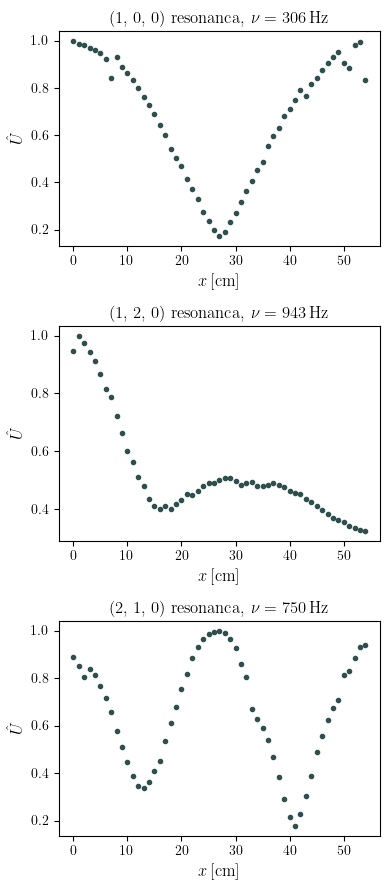

In [8]:
# Plot reponse for different microphone placements.
fig, axs = plt.subplots(3, 1, figsize=[4, 9])

res_list = [
    (306, (1, 0, 0), meas_dict['profil-306']),
    (943, (1, 2, 0), meas_dict['profil-942']),
    (750, (2, 1, 0), meas_dict['profil-750']),
]
for ax, (ν, (n_x, n_y, n_z), meas) in zip(axs, res_list):
    U_0, U_0_sq, U_0_lock = meas
    U_0_mean = U_0 + U_0_sq + U_0_lock
    U_0_mean /= np.max(U_0_mean)
    ax.scatter(range(len(U_0)), U_0_mean, color='darkslategrey', marker='.')
    
    # Labels and style.
    ax.set_title(f'({n_x}, {n_y}, {n_z}) resonanca, $\\nu = {ν:.0f}\\,\\mathrm{{Hz}}$')
    ax.set_xlabel(r'$x\,[\mathrm{cm}]$')
    ax.set_ylabel(r'$\hat U$')
fig.tight_layout()
fig.savefig('profiles.pdf')

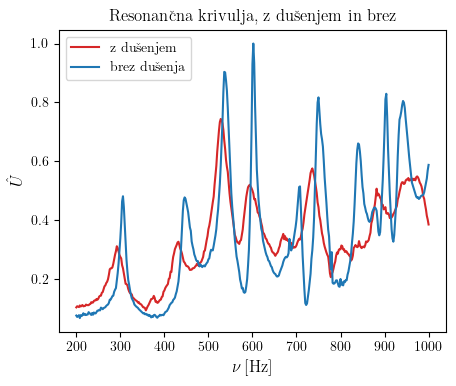

In [12]:
ν, U_0, U_0_sq, U_0_lock = meas_dict['res-odziv']
muff_ν, muff_U_0, muff_U_0_sq, muff_U_0_lock = meas_dict['res-odziv-dusen']
U_0_mean = (U_0 + U_0_sq + U_0_lock) / np.max(U_0 + U_0_sq + U_0_lock)
muff_U_0_mean = (muff_U_0 + muff_U_0_sq + muff_U_0_lock) / np.max(U_0 + U_0_sq + U_0_lock)


# Plot.
fig, ax = plt.subplots(1, 1, figsize=[5, 4])

ax.plot(muff_ν, muff_U_0_mean, color='tab:red', label='z dušenjem')
ax.plot(ν, U_0_mean, color='tab:blue', label='brez dušenja')

# Labels and style.
ax.set_title('Resonančna krivulja, z dušenjem in brez')
ax.set_xlabel(r'$\nu\,[\mathrm{Hz}]$')
ax.set_ylabel(r'$\hat U$')
ax.legend(loc='upper left')
fig.savefig('muff.pdf')